<a href="https://colab.research.google.com/github/andrewm4894/colabs/blob/master/time_series_anomaly_detection_with_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install netdata_pandas

In [2]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

from netdata_pandas.data import get_data


def anomaly_scores(pca, X):
    """Given a fitted pca model and some X feature vectors, compute an anomaly score as the sum of weighted euclidean distance between each sample to the
    hyperplane constructed by the selected eigenvectors. 
    """
    return np.sum(cdist(X, pca.components_) / pca.explained_variance_ratio_, axis=1).ravel()


def preprocess_df(df, lags_n, diffs_n, smooth_n, diffs_abs=False, abs_features=True):
    """Given a pandas dataframe preprocess it to take differences, add smoothing, and lags as specified. 
    """
    if diffs_n >= 1:
        # take differences
        df = df.diff(diffs_n).dropna()
        # abs diffs if defined
        if diffs_abs == True:
            df = abs(df)
    if smooth_n >= 2:
        # apply a rolling average to smooth out the data a bit
        df = df.rolling(smooth_n).mean().dropna()
    if lags_n >= 1:
        # for each dimension add a new columns for each of lags_n lags of the differenced and smoothed values for that dimension
        df_columns_new = [f'{col}_lag{n}' for n in range(lags_n+1) for col in df.columns]
        df = pd.concat([df.shift(n) for n in range(lags_n + 1)], axis=1).dropna()
        df.columns = df_columns_new
    # sort columns to have lagged values next to each other for clarity when looking at the feature vectors
    df = df.reindex(sorted(df.columns), axis=1)

    # abs all features if specified
    if abs_features == True:
        df = abs(df)
    
    return df

/usr/local/lib/python3.7/dist-packages/trio/_core/_multierror.py:464: RuntimeWarning: IPython detected, but you already have a custom exception handler installed. I'll skip installing Trio's custom handler, but this means MultiErrors will not show full tracebacks.
  category=RuntimeWarning,


In [3]:
# inputs 
host = 'london.my-netdata.io'  # pull from 'london' netdata demo host
after = -3600  # last 60 minutes
before = 0  # starting from now
dims = ['system.cpu|system']  # lets just look at syatem cpu data

# params
n_train = 3000  # use the last 50 minutes of data to train on
diffs_n = 1  # take differences
lags_n = 3  # include 3 lags in the feature vector
smooth_n = 3  # smooth the latest values to be included in the feature vector

In [4]:
# get raw data
df = get_data(
    hosts=[host], 
    charts=list(set([d.split('|')[0] for d in dims])), 
    after=after, 
    before=before, 
    index_as_datetime=True
)
df = df[dims]

# look at raw data
print(df.shape)
display(df.head())

(3600, 1)


,system.cpu|system
time_idx,
2021-10-11 14:55:56,0.501253
2021-10-11 14:55:57,0.503778
2021-10-11 14:55:58,1.256281
2021-10-11 14:55:59,0.502513
2021-10-11 14:56:00,0.503778


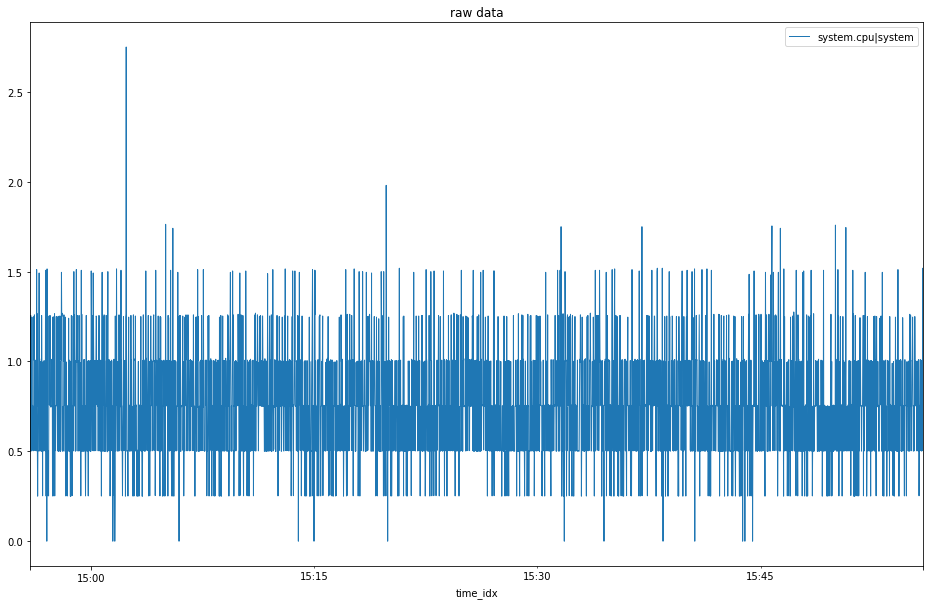

In [5]:
# plot the raw data
df.plot(title='raw data', figsize=(16,10), lw=1)

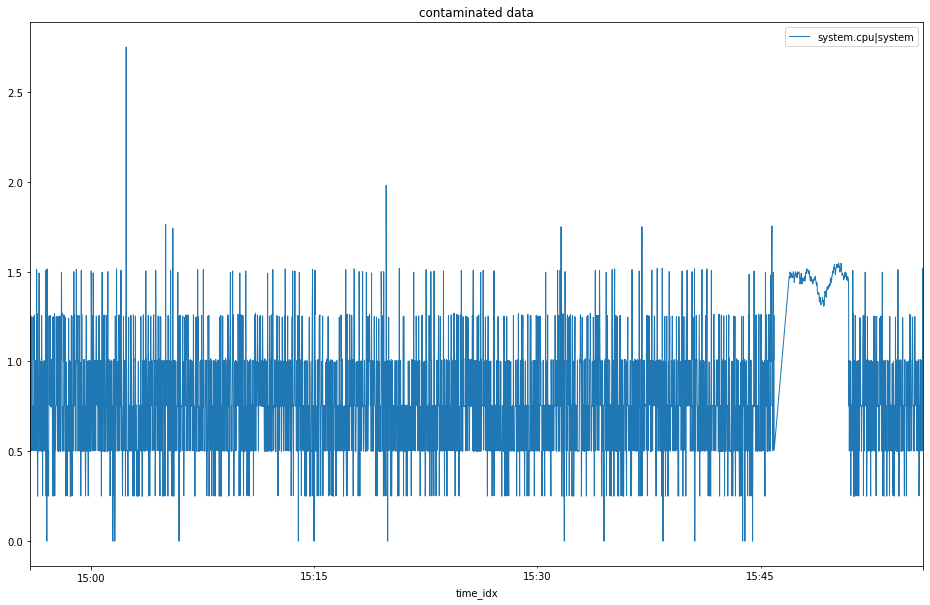

In [6]:
# create train data
df_train = df.head(n_train)

# preprocess or 'featurize' the training data
train_data = preprocess_df(df_train, lags_n, diffs_n, smooth_n)

# create anomalous data
anomalous_len = int((len(df) - n_train) / 2)  # we pick half of our anomalous window to mess up
df_anomalous = df.tail(anomalous_len + anomalous_len)  # get the tail end of our raw data
df_anomalous = df_anomalous.head(anomalous_len)  # take the top part of it we want to mess with
df_anomalous[dims] = df_anomalous.sample(frac=1).values  # scramble the data
df_anomalous = df_anomalous.rolling(60).mean()*2  # apply a 60 seconds rolling avg to smooth it so that it looks much different

# preprocess or 'featurize' the anomalous data
anomalous_data = preprocess_df(df_anomalous, lags_n, diffs_n, smooth_n)

# append train data and anomalous data as 'contaminated' data
df_contaminated = df_train.append(df_anomalous).append(df.tail(anomalous_len)).interpolate(method='linear')
df_contaminated.plot(title='contaminated data', figsize=(16,10), lw=1)

# preprocess or 'featurize' the contaminated data
contaminated_data = preprocess_df(df_contaminated, lags_n, diffs_n, smooth_n)

In [7]:
# build PCA model
pca = PCA(n_components=2)

# scale based on training data
scaler = StandardScaler()
scaler.fit(train_data)

# fit model
pca.fit(scaler.transform(train_data))

# get anomaly scores for training data
train_scores = anomaly_scores(pca, scaler.transform(train_data))
df_train_scores = pd.DataFrame(train_scores, columns=['anomaly_score'], index=train_data.index)
df_train_scores_min = df_train_scores.min()
df_train_scores_max = df_train_scores.max()

# normalize anomaly scores on based training data
df_train_scores = ( df_train_scores - df_train_scores_min ) / ( df_train_scores_max - df_train_scores_min )

In [8]:
# score all contaminated data
contaminated_scores = anomaly_scores(pca, scaler.transform(contaminated_data))
df_contaminated_scores = pd.DataFrame(contaminated_scores, columns=['anomaly_score'], index=contaminated_data.index)

# normalize based on train data scores
df_contaminated_scores = ( df_contaminated_scores - df_train_scores_min ) / ( df_train_scores_max - df_train_scores_min )

# add rolling mean of scores to smooth more
df_contaminated_scores_smoothed = df_contaminated_scores.rolling(15).mean()

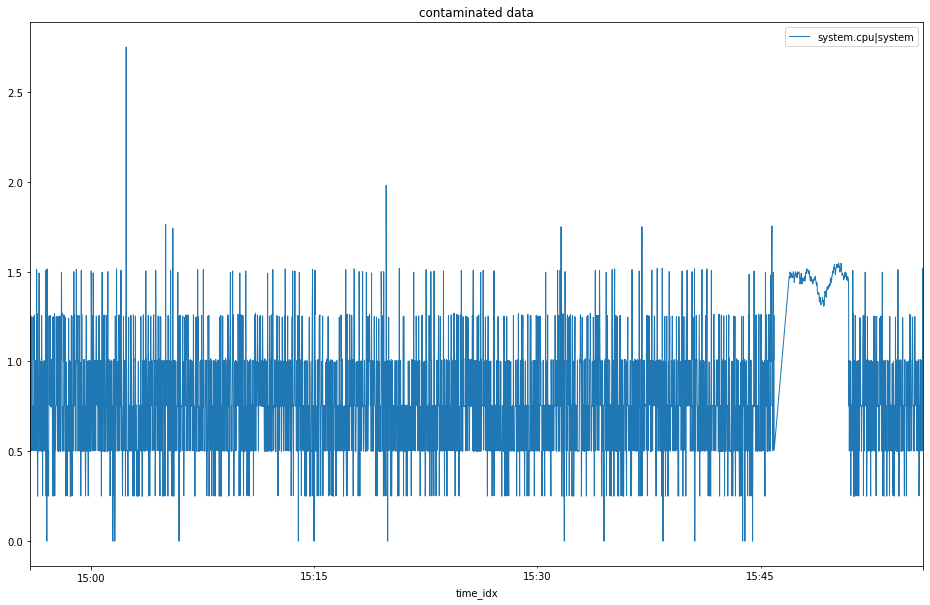

In [9]:
df_contaminated.plot(title='contaminated data', figsize=(16,10), lw=1)

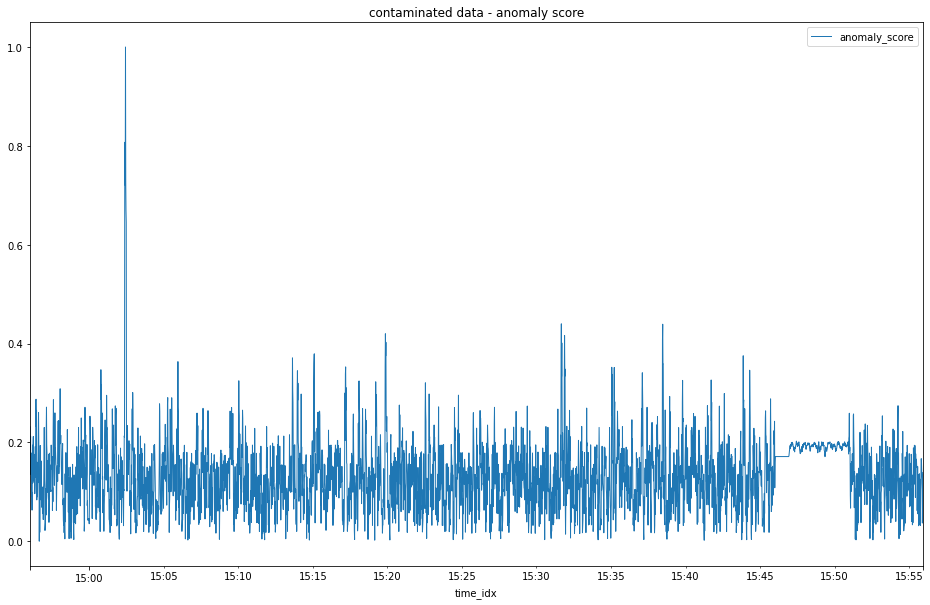

In [10]:
df_contaminated_scores.plot(title='contaminated data - anomaly score', figsize=(16,10), lw=1)

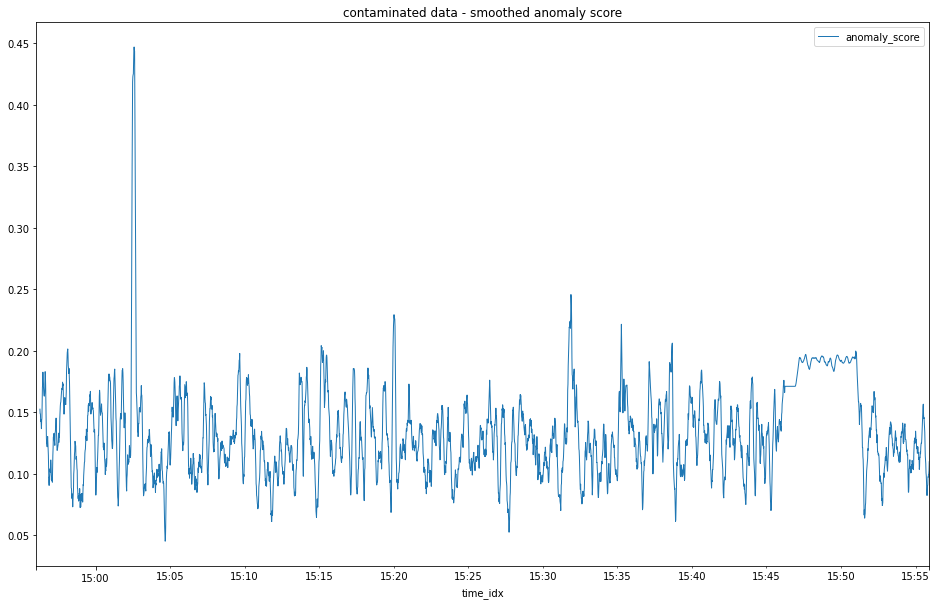

In [11]:
df_contaminated_scores_smoothed.plot(title='contaminated data - smoothed anomaly score', figsize=(16,10), lw=1)

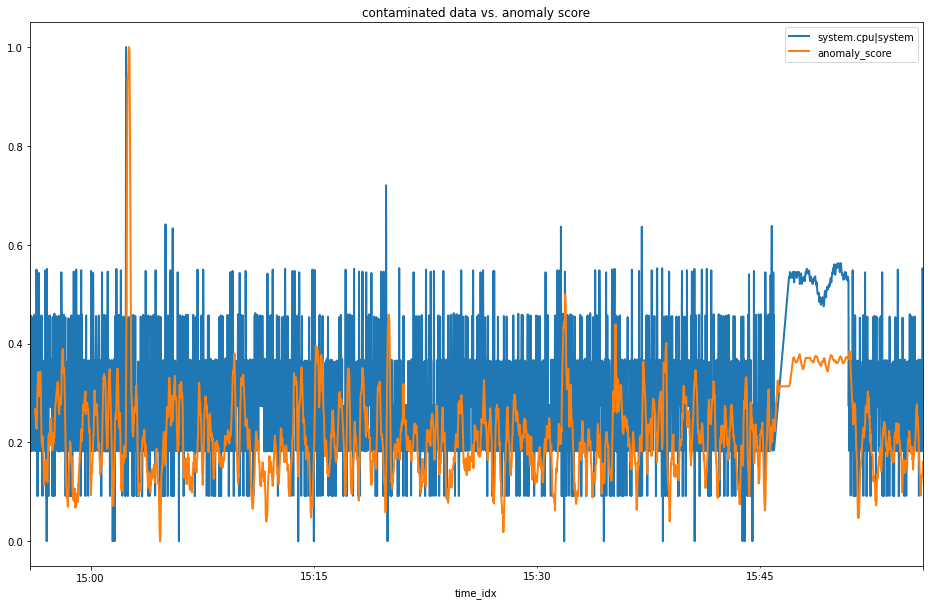

In [12]:
# plot data and anomaly score together
df_final = df_contaminated.join(df_contaminated_scores_smoothed)
df_final = (df_final-df_final.min())/(df_final.max()-df_final.min())
df_final.plot(title='contaminated data vs. anomaly score', figsize=(16,10), lw=2)